In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import gaia_download as gd
import matplotlib.pyplot as plt
import click
from download_isochrone import load_isochrone
from scipy.interpolate import interp1d
import os
from sklearn.ensemble import IsolationForest

In [3]:
cluster_name = 'NGC 188'

In [4]:
clustered_sources = pd.read_csv(f'data/{cluster_name}/{cluster_name}_clustered.csv')
isochrone: np.ndarray = load_isochrone(f'data/{cluster_name}/{cluster_name}_isochrone.dat')
isochrone=isochrone[:120]

In [5]:
sources = clustered_sources[['BP-RP', 'G_abs']].values
BOUNDS = np.max(isochrone, axis=0)-np.min(isochrone, axis=0)

#clf = IsolationForest(contamination=.25).fit_predict(clustered_sources[['BP-RP', 'G_abs']].values)
#clustered_sources['outlier'] = clf

def closest(source, isochrone):
    closest = isochrone[
    np.argsort(
            np.linalg.norm((source-isochrone), axis=1).flatten()
        )
    ][:5]
    return closest[np.argmin(closest[:, 0])], closest[np.argmax(closest[:, 0])]

def distance_to_closest(source, isochrone):
    src_rescaled = source/BOUNDS
    isochrone_rescaled = isochrone/BOUNDS
    p1, p2 = closest(src_rescaled, isochrone_rescaled)
    return np.linalg.norm(np.cross((p2-p1), (p1-src_rescaled)))/np.linalg.norm((p2-p1))

def above_isochrone(source, isochrone):
    closest = isochrone[
        np.argsort(
                np.linalg.norm((source-isochrone), axis=1).flatten()
            )
    ][:3]
    p1 = closest[np.argmin(closest[:, 0])]
    p2 = closest[np.argmax(closest[:, 0])]
    v1 = (p2[0]-p1[0], p2[1]-p1[1])   # Vector 1
    v2 = (p2[0]-source[0], p2[1]-source[1])   # Vector 2
    xp = v1[0]*v2[1] - v1[1]*v2[0]  # Cross product

    return xp+.2>=0

dists = np.apply_along_axis(
    lambda x: distance_to_closest(x, isochrone), 1,
    sources
)

In [6]:
from sklearn.preprocessing import StandardScaler
normalized_par_over_err = StandardScaler().fit_transform(clustered_sources.parallax_over_error.values.reshape(-1, 1))
normalized_par_over_err = (normalized_par_over_err-np.min(normalized_par_over_err))/(np.max(normalized_par_over_err)-np.min(normalized_par_over_err))

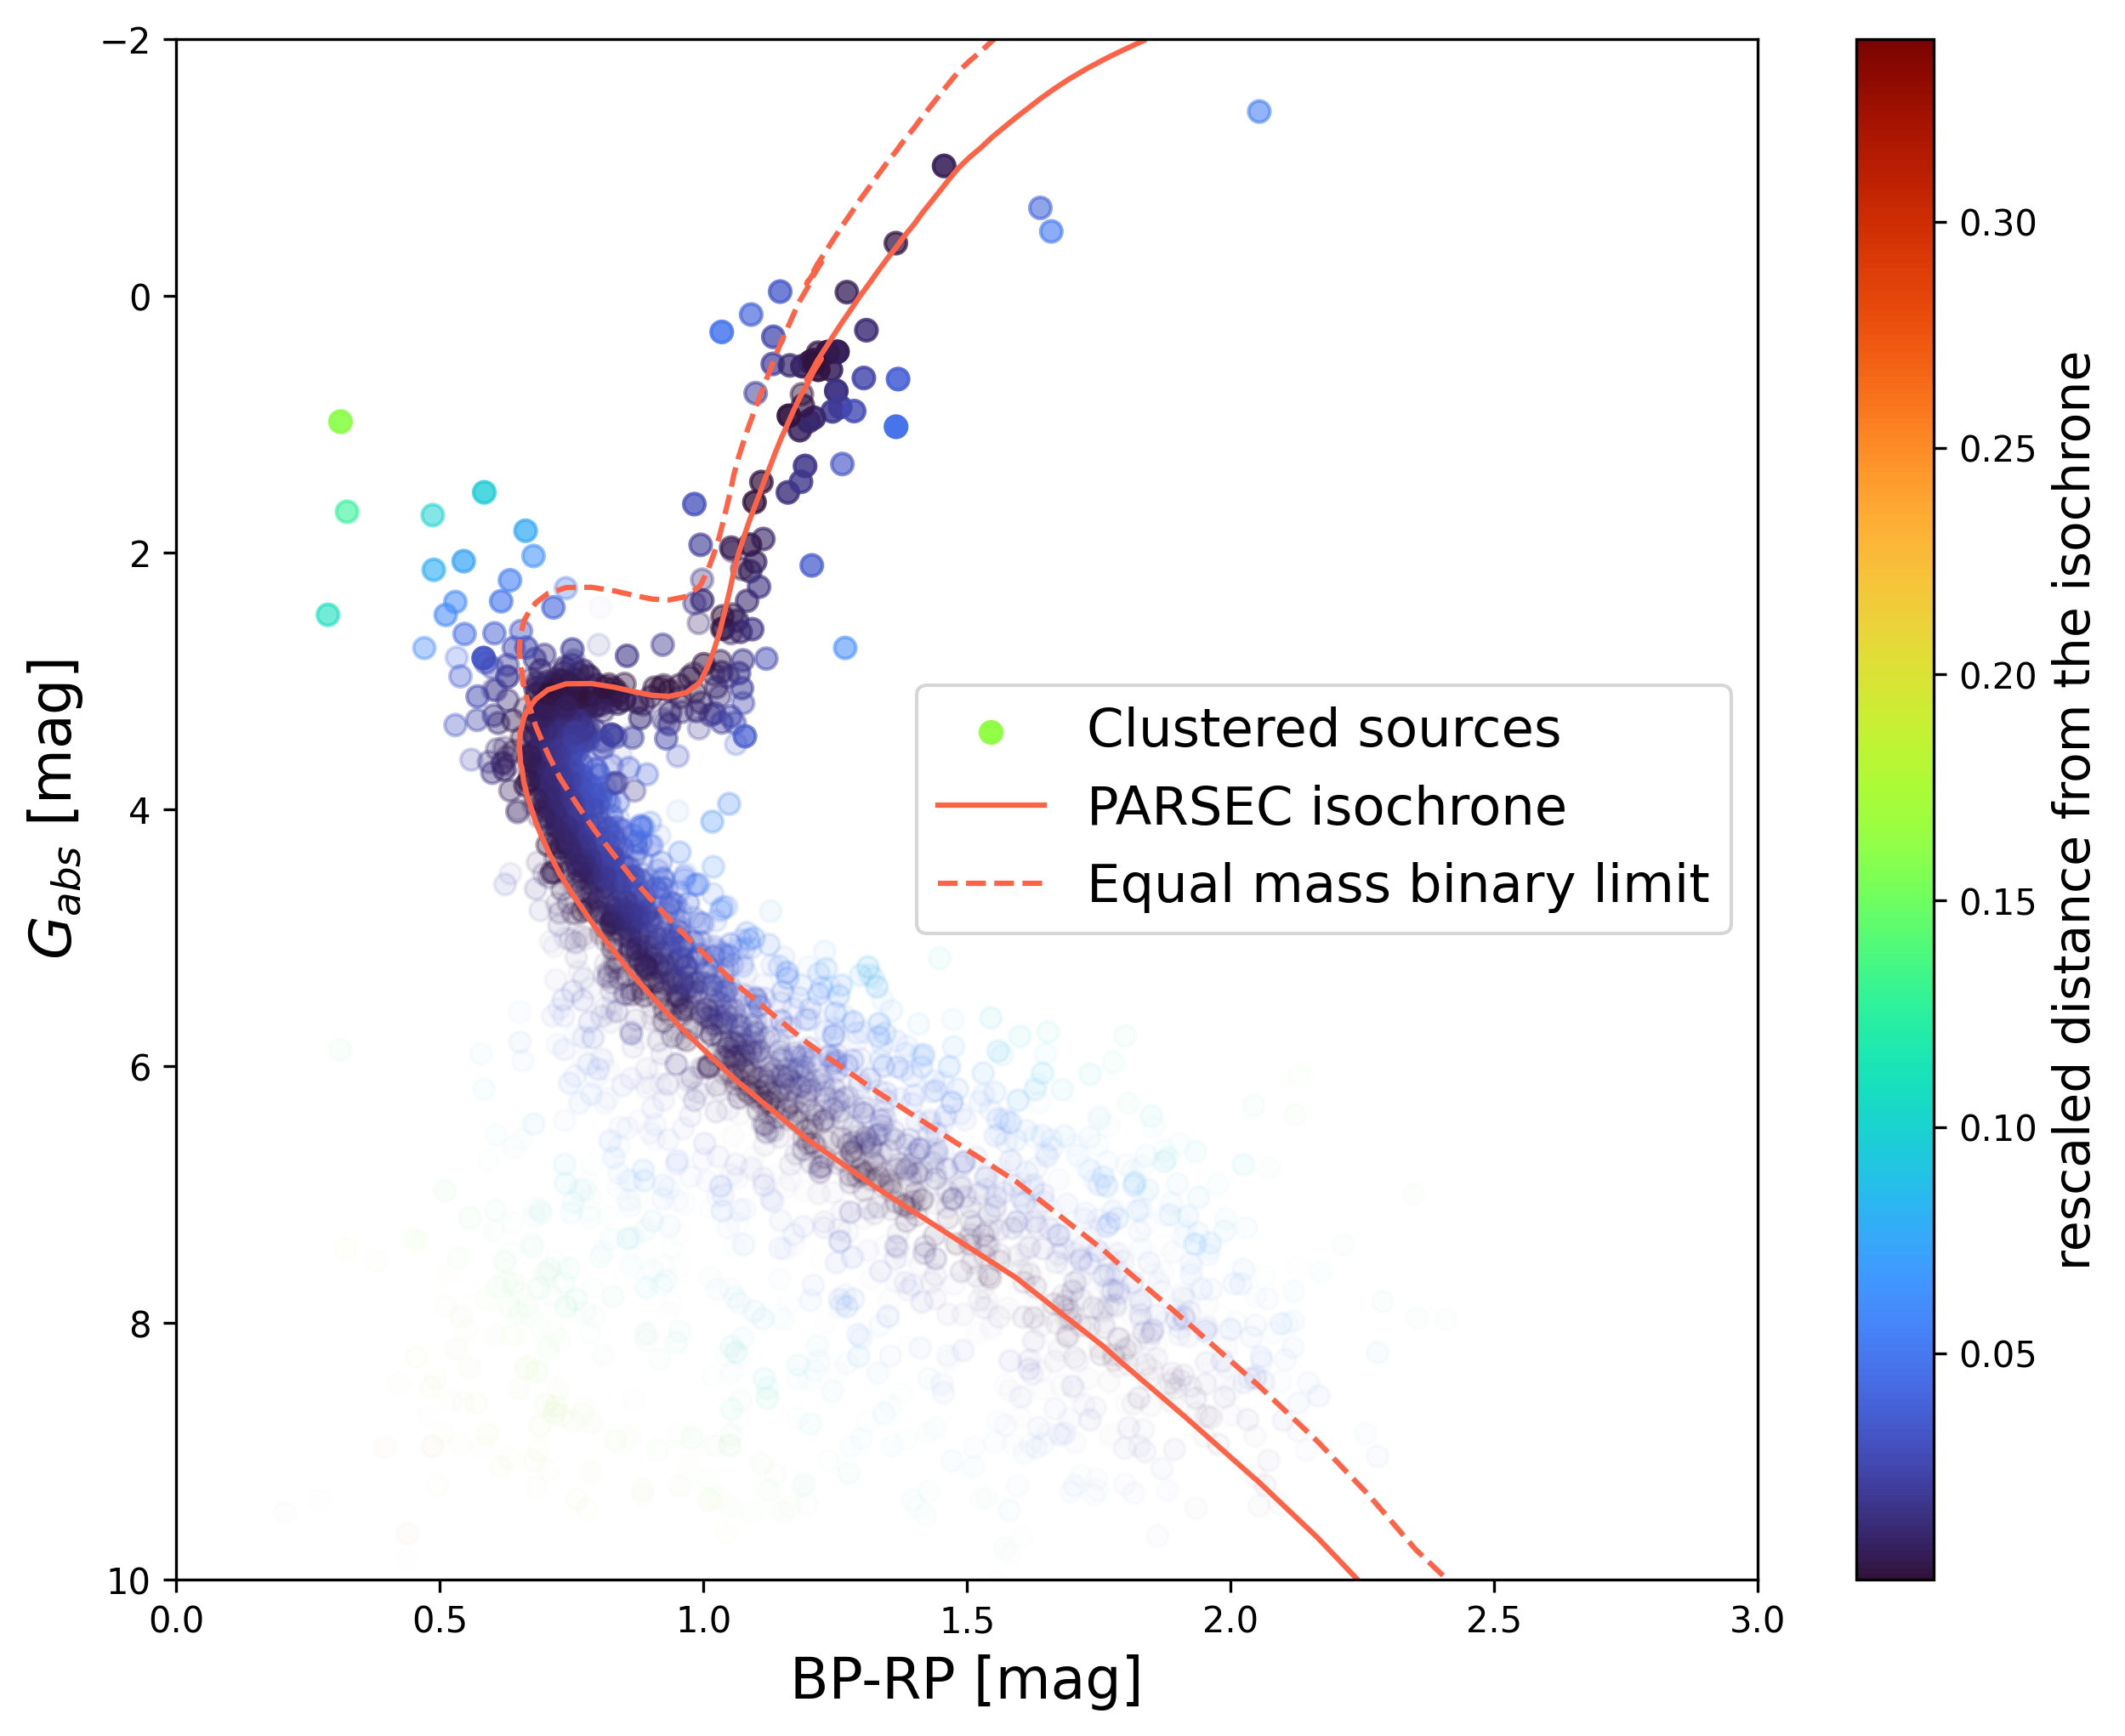

In [7]:
dist_std = np.nanstd(dists)

fig = plt.figure(figsize=(10, 8), dpi=300);
plt.scatter(clustered_sources['BP-RP'], clustered_sources['G_abs'],
            c=dists, cmap='turbo', label='Clustered sources', alpha=normalized_par_over_err)
cbar = plt.colorbar()
cbar.set_label('rescaled distance from the isochrone', fontsize=14)
plt.gca().set_ylabel('$G_{abs}$ [mag]', fontsize=16);
plt.gca().set_xlabel('BP-RP [mag]', fontsize=16);
plt.plot(isochrone[:, 0], isochrone[:, 1], label='PARSEC isochrone', color='tomato')
plt.plot(isochrone[:, 0], isochrone[:, 1]-0.75, label='Equal mass binary limit', color='tomato', linestyle='--')
plt.gca().invert_yaxis();
lgnd = plt.legend(fontsize=15);
for handle in lgnd.legendHandles:
    handle._alpha = 1.;

plt.gca().set_ylim(10., -2.);
plt.gca().set_xlim(0, 3);

In [8]:
clf = IsolationForest(contamination=.25).fit_predict(clustered_sources[['BP-RP', 'G_abs']].dropna().values)
clustered_sources = clustered_sources.dropna(subset=['BP-RP', 'G_abs'])
clustered_sources['outlier'] = clf

In [9]:
outliers = clustered_sources[clustered_sources.outlier==-1]
non_outliers = clustered_sources[clustered_sources.outlier!=-1]

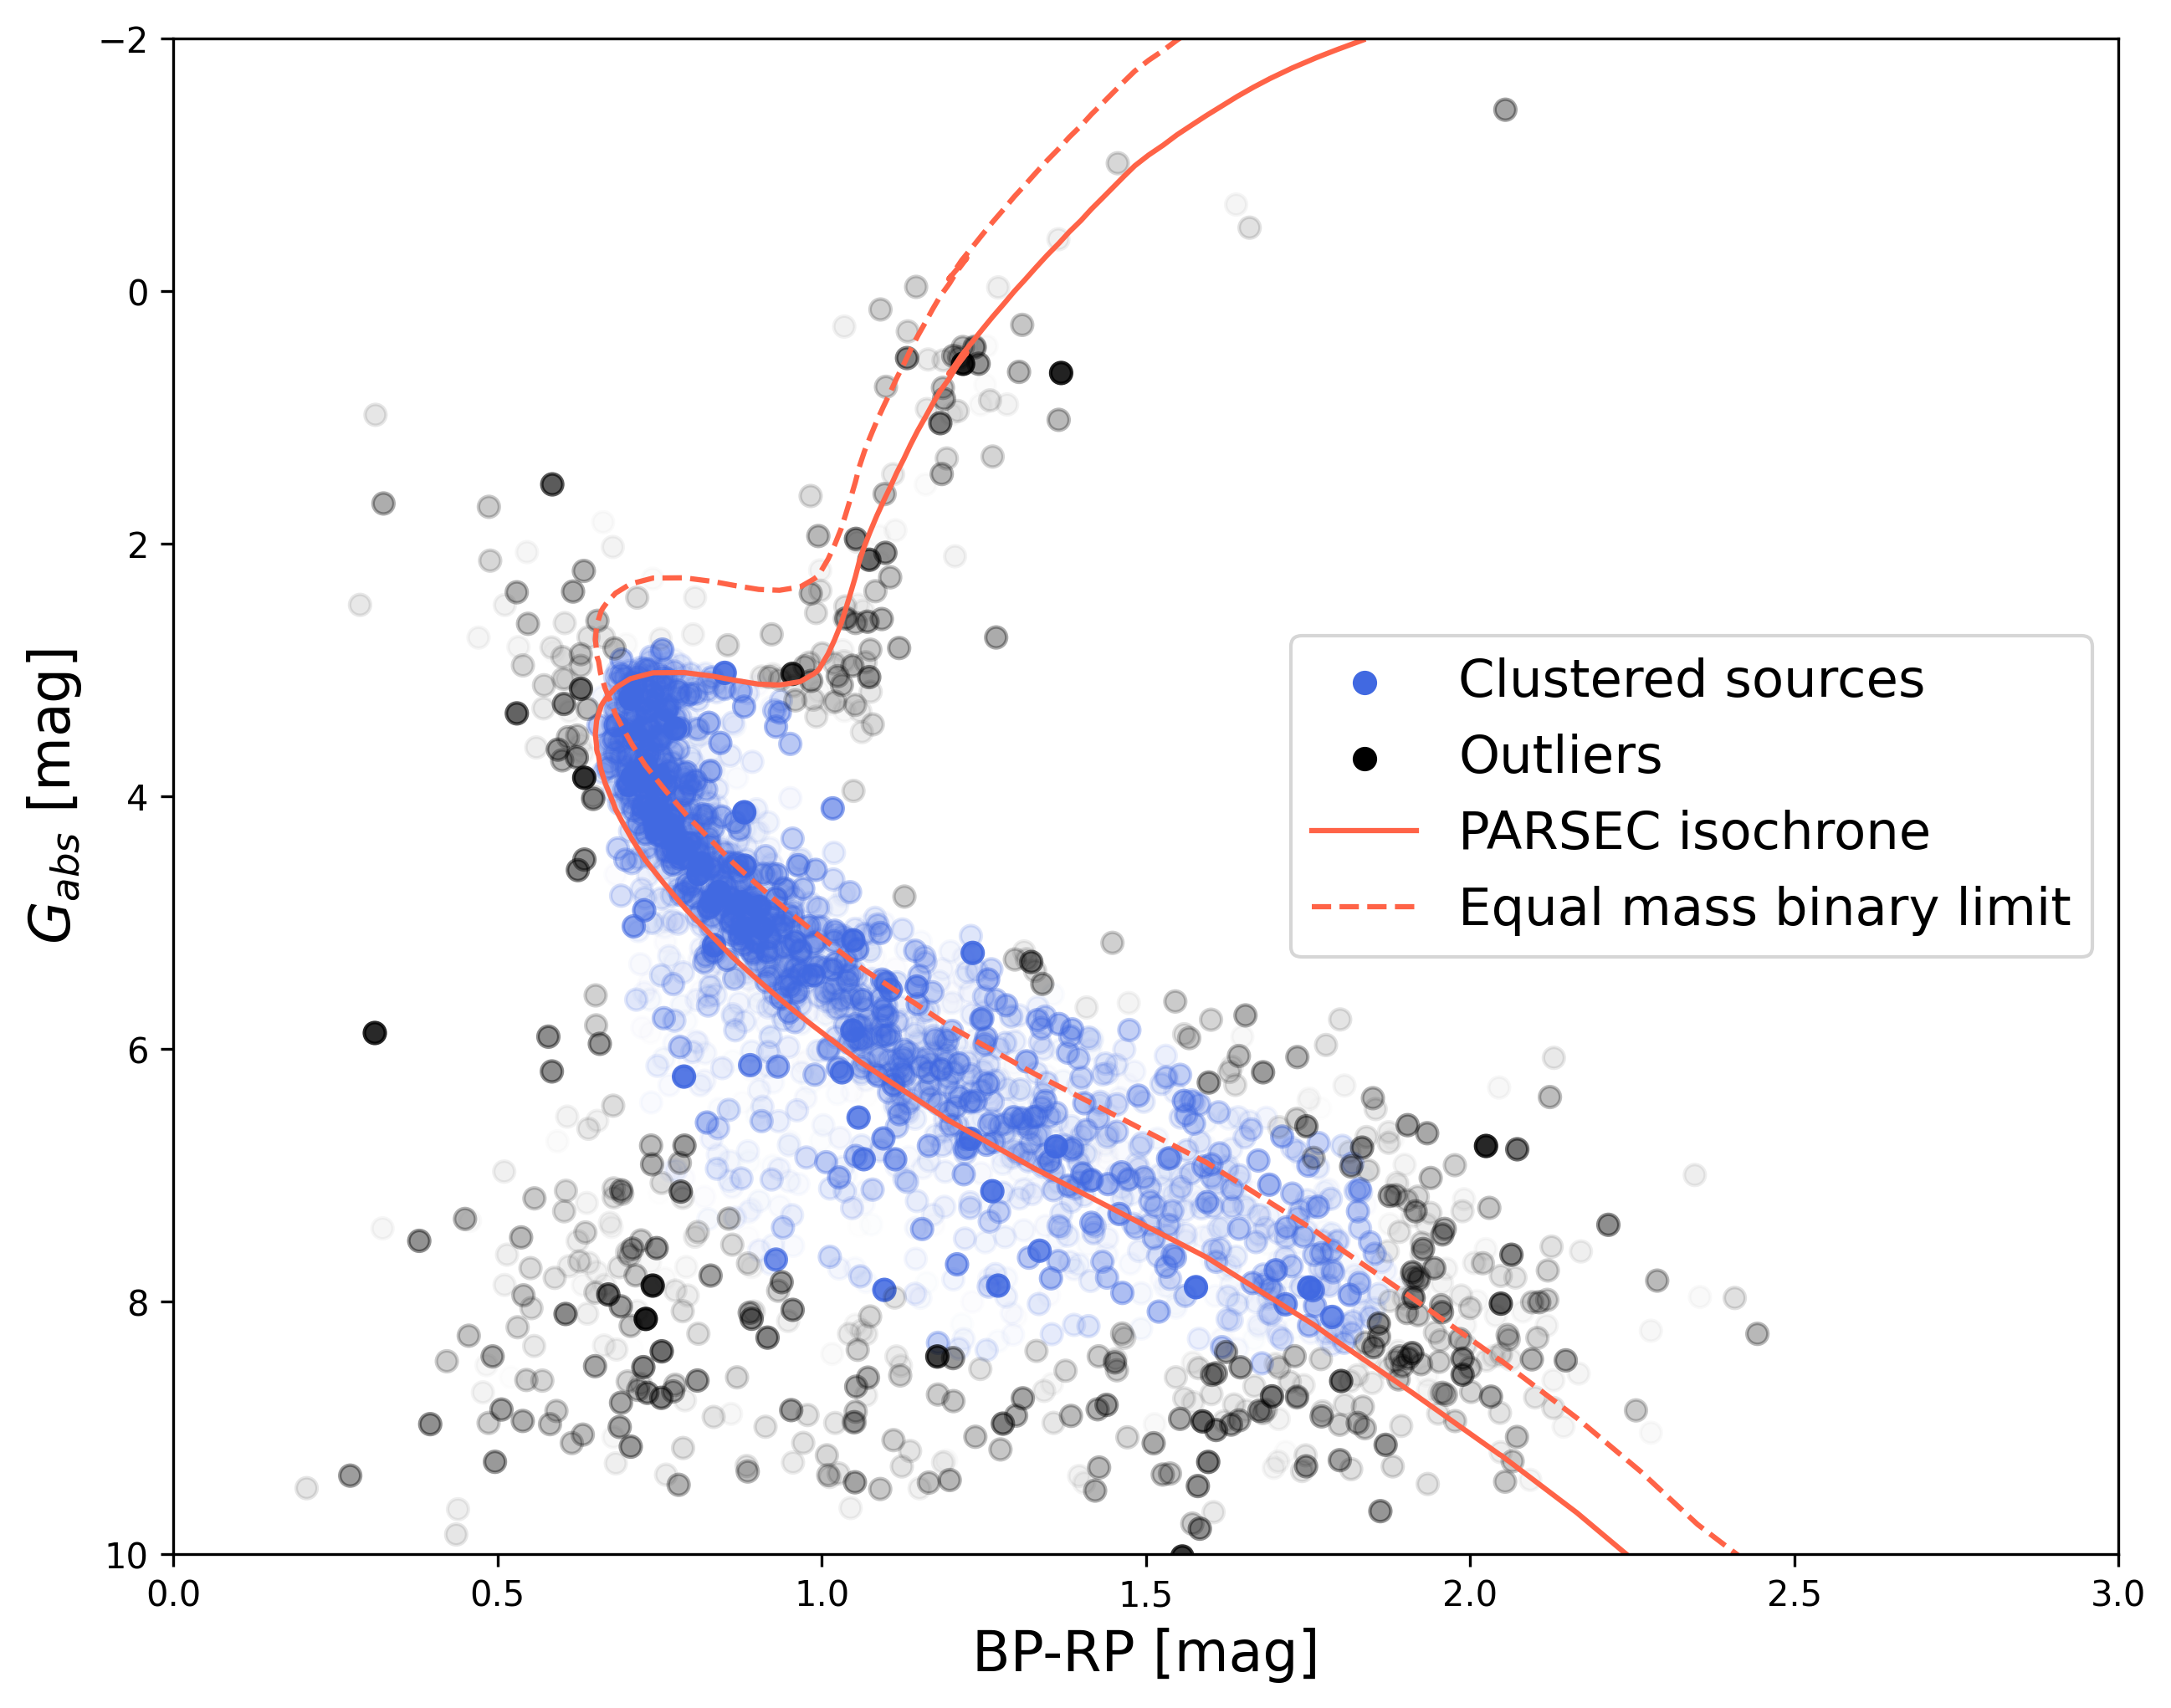

In [10]:
fig = plt.figure(figsize=(10, 8), dpi=300);
plt.scatter(non_outliers['BP-RP'], non_outliers['G_abs'],
            color='royalblue', label='Clustered sources', alpha=normalized_par_over_err)
plt.scatter(outliers['BP-RP'], outliers['G_abs'],
            color='black', label='Outliers', alpha=normalized_par_over_err)
cbar.set_label('rescaled distance from the isochrone', fontsize=14)
plt.gca().set_ylabel('$G_{abs}$ [mag]', fontsize=16);
plt.gca().set_xlabel('BP-RP [mag]', fontsize=16);
plt.plot(isochrone[:, 0], isochrone[:, 1], label='PARSEC isochrone', color='tomato')
plt.plot(isochrone[:, 0], isochrone[:, 1]-0.75, label='Equal mass binary limit', color='tomato', linestyle='--')
plt.gca().invert_yaxis();
lgnd = plt.legend(fontsize=15);
for handle in lgnd.legendHandles:
    handle._alpha = 1.;

plt.gca().set_ylim(10., -2.);
plt.gca().set_xlim(0, 3);